# Camera Calibration

Camera calibration involves using the linear model of the camera to solve for the following:

1. Intrinsic Matrix (M<sub>int</sub> = [K|0])
	- Calibration Matrix or Camera Matrix (K<sub>3x3</sub>  (upper triangular matrix))
2. Extrinsic Matrix (Mext = [ [R<sub>3x3</sub> t<sub>3x1</sub>], [0<sub>1x3</sub> 1] ])
	- Rotation Matrix (R<sub>3x3</sub>)
	- Translation Matrix (t<sub>3x1</sub>)
3. Projection Matrix (p = M<sub>int</sub>.M<sub>ext</sub>)
	- Is the matrix product of the intrinsic and extrinsics

## Steps

1. Find several points in the image corresponding to some points in 3D space (2D-3D mapping)
2. Solve for Projection Matrix p
3. Use QR Decomposition of p[:3,:3] to get K, R
4. Solving Kt = p[:3,3] to get Translation Matrix t

In [1]:
# NOTE: OpenCV is only used to aquire points and verify results

import cv2
import numpy as np
import os
import glob

import matplotlib.pyplot as plt

## 1. Find several points in the image corresponding to some points in 3D space (2D-3D mapping)

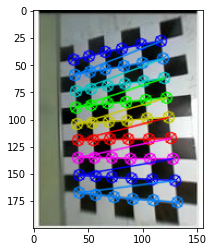

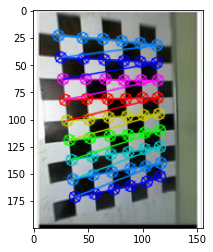

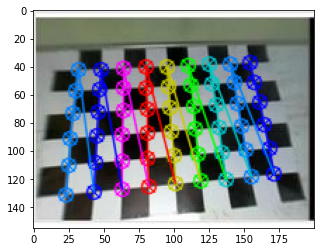

In [2]:
# Define the dimensions of checkerboard
CHECKERBOARD = (6, 9)

# stop the iteration when specified
# accuracy, epsilon, is reached or
# specified number of iterations are completed.
criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Vector for 3D points
threedpoints = []
 
# Vector for 2D points
twodpoints = []


#  3D points real world coordinates
objectp3d = np.zeros((1, CHECKERBOARD[0]
                      * CHECKERBOARD[1],
                      3), np.float32)
objectp3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0],
                               0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

# Extracting path of individual image stored
# in a given directory. Since no path is
# specified, it will take current directory
# jpg files alone
images = glob.glob('*.jpg')

for filename in images:
    image = cv2.imread(filename)
    grayColor = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
    # Find the chess board corners
    # If desired number of corners are
    # found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(
                    grayColor, CHECKERBOARD,
                    cv2.CALIB_CB_ADAPTIVE_THRESH
                    + cv2.CALIB_CB_FAST_CHECK +
                    cv2.CALIB_CB_NORMALIZE_IMAGE)
 
    # If desired number of corners can be detected then,
    # refine the pixel coordinates and display
    # them on the images of checker board
    if ret == True:
        threedpoints.append(objectp3d)
 
        # Refining pixel coordinates
        # for given 2d points.
        corners2 = cv2.cornerSubPix(
            grayColor, corners, (11, 11), (-1, -1), criteria
        )
 
        twodpoints.append(corners2)
 
        # Draw and display the corners
        image = cv2.drawChessboardCorners(image,
                                          CHECKERBOARD,
                                          corners2, ret)
        plt.figure()
        plt.imshow(image)
        
twodpoints = np.array(twodpoints)
threedpoints = np.array(threedpoints)
img_points = []
obj_points = []
for i in range(len(twodpoints)):
#for i in range(len(twodpoints[:1])):
    for j in range(len(twodpoints[i])):
        #print(twodpoints[i][j][0], '->', threedpoints[i][0][j])
        img_points.append(twodpoints[i][j][0])
        obj_points.append(threedpoints[i][0][j])

In [3]:
print("[ ui vi ]\t\t->\t[xw yw zw]")
for i in range(5):
    print(img_points[i], '->', obj_points[i], sep='\t')
    
print('...', '(' + str(len(img_points)) + ' such points)')

[ ui vi ]		->	[xw yw zw]
[37.464664 44.546795]	->	[0. 0. 0.]
[50.85375 41.60677]	->	[1. 0. 0.]
[65.58785  38.231873]	->	[2. 0. 0.]
[81.41715  34.834583]	->	[3. 0. 0.]
[98.59042  31.407478]	->	[4. 0. 0.]
... (162 such points)


## 2. Solve for Projection Matrix p

Solve for projection matrix p from `Ap=0` subject to the constraint 

||p||<sup>2</sup> = 1

Define loss function:

L(p, $\lambda$) = ||Ap||<sup>2</sup> - $\lambda$.(||p||<sup>2</sup> - 1)


Equate the first derivative to 0, we get

AT.A.p = $\lambda$ .p

Solve this Eigenvalue Problem as follows:
```python
values, vectors = np.linalg.eig(np.matmul(A.T, A))


# Eigen vector corresponding to the smallest eigen value of AT.A will give p
p = vectors[np.argmin(values)]

p = np.reshape(p, (3,4) )
```

In [4]:
# Construct A

A = np.zeros((2*len(img_points), 12))

for i in range(0, len(img_points), 2):
    xyz1 = np.concatenate((obj_points[i], [1]), axis=0)
    A[i] = np.concatenate( (xyz1, [0]*4, -img_points[i][0]*xyz1), axis=0 )
    A[i+1] = np.concatenate( ([0]*4, xyz1, -img_points[i][1]*xyz1), axis=0 )

print(A)

[[  0.           0.           0.         ...  -0.          -0.
  -37.46466446]
 [  0.           0.           0.         ...  -0.          -0.
  -44.54679489]
 [  2.           0.           0.         ...  -0.          -0.
  -65.58785248]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


In [5]:
# Solve for projection matrix p from Ap=0 subject to the constraint ||p||^2 = 1
# Define loss function
# L(p, Lambda) = ||Ap||^2 - Lambda.(||p||^2 - 1)

# Equate the first derivative to 0, we get
# AT.A.p = Lambda.p
# Solve this Eigenvalue Problem

"""
w(…, M) array
The eigenvalues, each repeated according to its multiplicity.
The eigenvalues are not necessarily ordered.
The resulting array will be of complex type, unless the imaginary part 
    is zero in which case it will be cast to a real type. 
When a is real the resulting eigenvalues will be real (0 imaginary part) or occur in conjugate pairs

v(…, M, M) array
The normalized (unit “length”) eigenvectors, such that the column v[:,i] 
    is the eigenvector corresponding to the eigenvalue w[i].
"""

w, v = np.linalg.eig(np.matmul(A.T, A))


# Eigen vector corresponding to the smallest eigen value of AT.A will give p
p = v[np.argmin(w)]

p = np.reshape(p, (3,4) )

p

array([[-8.92208329e-01, -4.38059154e-01,  1.09629250e-01,
        -5.60428541e-04],
       [ 6.75330976e-03, -7.43859332e-06,  1.86987840e-03,
        -6.91382462e-04],
       [-8.55574855e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

## 3. Use QR Decomposition of p[:3,:3] to get K, R
## 4. Solving Kt = p[:3,3] to get Translation Matrix t

In [6]:
# QR Decomposition of p[:3,:3] to get Calibration Matrix K and Rotation Matrix R
K, R = np.linalg.qr(p[:3,:3])

# Solving Kt = p[:3,3] to get Translation Matrix t
t = np.matmul(np.linalg.inv(K), p[:3,3])

K, R, t

(array([[-9.99971350e-01, -7.56959780e-03, -2.14630529e-07],
        [ 7.56899041e-03, -9.99891470e-01,  1.26396032e-02],
        [-9.58913199e-05,  1.26392395e-02,  9.99920117e-01]]),
 array([[ 8.92233891e-01,  4.38046548e-01, -1.09611956e-01],
        [ 0.00000000e+00,  3.32336940e-03, -2.69952479e-03],
        [ 0.00000000e+00,  0.00000000e+00,  2.36109912e-05]]),
 array([ 5.55179418e-04,  6.95549644e-04, -8.73867970e-06]))

In [7]:
# Use OpenCV to calibrate

# Perform camera calibration by
# passing the value of above found out 3D points (threedpoints)
# and its corresponding pixel coordinates of the
# detected corners (twodpoints)

"""
cv.calibrateCamera(
    objectPoints, imagePoints, imageSize, 
    cameraMatrix, 
    distCoeffs
    
    [, rvecs[, tvecs[, flags[, criteria]]]]
"""

ret, K_cv, distortion, R_cv, t_cv = cv2.calibrateCamera(
    threedpoints, twodpoints, grayColor.shape[::-1], None, None
)
 
 
# Displaying required output
print(" Calibration Matrix (or Camera matrix):")
print(K_cv)
 
print("\n Distortion coefficient:")
print(distortion)
 
print("\n Rotation Vectors:")
print(R_cv)
 
print("\n Translation Vectors:")
print(t_cv)


 Calibration Matrix (or Camera matrix):
[[81.30738412  0.         83.34301324]
 [ 0.         81.79288801 89.29112331]
 [ 0.          0.          1.        ]]

 Distortion coefficient:
[[ 0.02492663 -0.05784454 -0.01679264 -0.00466377  0.02481461]]

 Rotation Vectors:
(array([[-0.0990877 ],
       [ 0.19139989],
       [-0.08127205]]), array([[-3.06377348e-01],
       [-2.17234539e-03],
       [ 3.06666055e+00]]), array([[-0.18125369],
       [ 0.14325047],
       [ 1.50809295]]))

 Translation Vectors:
(array([[-3.04562814],
       [-3.03232775],
       [ 5.6628169 ]]), array([[2.3379225 ],
       [4.36774935],
       [5.34070258]]), array([[ 4.68713674],
       [-3.30821253],
       [ 5.39689926]]))
